In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import (
    SortedSpikesClassifier,
    ClusterlessClassifier,
)

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [4]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_replay_info_67.csv")
)
replay_info = pd.concat(
    [pd.read_csv(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_Cont_avg_prob  \
Animal ID day epoch ripple_number                                         
cor       1   2     1                   False                       NaN   
                    2                   False                       NaN   
                    3                   False                       NaN   
                    4                    True                  0.945581   
                    5                   False                       NaN   

                                   Continuous_Frag_avg_prob  \
Animal ID day epoch ripple_number                             
cor       1   2     1                                   NaN   
                    2                                   NaN   
                    3                                   NaN   
                    4                                0.0132   
                    5                                   NaN   

                                   Continuous_Hov_avg_prob  \
Animal ID day epoch ripple_number                            
cor       1   2     1                                  NaN   
                    2                                  NaN   
                    3                                  NaN   
                    4                             0.041219   
                    5                                  NaN   

                                   Continuous_duration  \
Animal ID day epoch ripple_number                        
cor       1   2     1                             0.00   
                    2                             0.00   
                    3                             0.00   
                    4                             0.08   
                    5                             0.00   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.433000   
                    2                                0.145381   
                    3                                0.253176   
                    4                                0.984090   
                    5                                0.471484   

                                   Continuous_max_time  Continuous_min_time  \
Animal ID day epoch ripple_number                                             
cor       1   2     1                              NaN                  NaN   
                    2                              NaN                  NaN   
                    3                              NaN                  NaN   
                    4                            0.078                  0.0   
                    5                              NaN                  NaN   

                                   Continuous_n_total_spikes  \
Animal ID day epoch ripple_number                              
cor       1   2     1                                    NaN   
                    2                                    NaN   
                    3                                    NaN   
                    4                                  114.0   
                    5                                    NaN   

                                   Continuous_n_unique_spiking  ...  \
Animal ID day epoch ripple_number                               ...   
cor       1   2     1                                      NaN  ...   
                    2                                      NaN  ...   
                    3                                      NaN  ...   
                    4                                      9.0  ...   
                    5                                      NaN  ...   

                                   spatial_coverage  \
Animal ID day epoch ripple_number                     
cor       1   2     1                     56.079072   
                    2                     25.298829   
                    3                     16.320

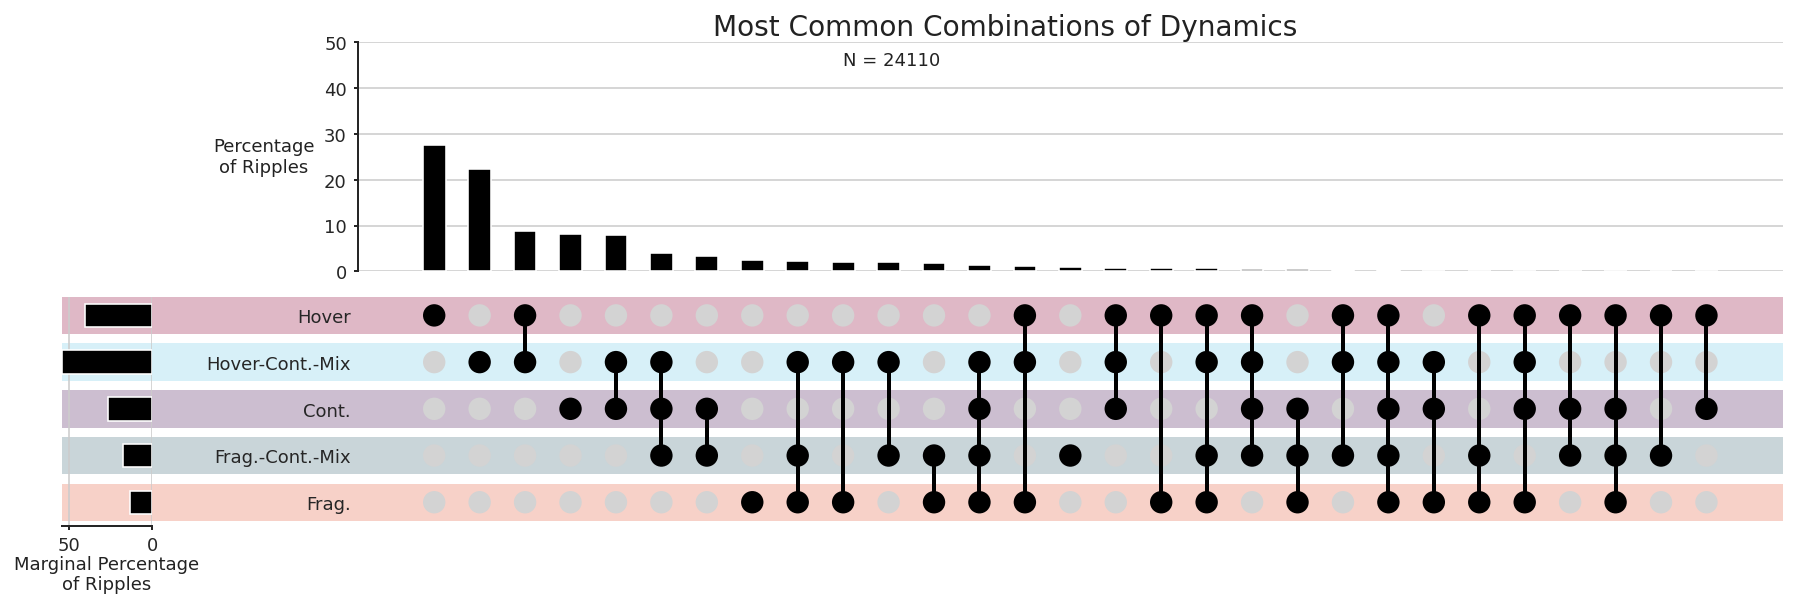

In [5]:
from src.visualization import SHORT_STATE_NAMES
from src.parameters import SHORT_STATE_ORDER, STATE_ORDER
from upsetplot import UpSet


def plot_category_counts(replay_info):
    df = replay_info.rename(columns=SHORT_STATE_NAMES).set_index(
        SHORT_STATE_ORDER[::-1]
    )
    upset = UpSet(
        df,
        sort_sets_by=None,
        show_counts=False,
        subset_size="count",
        sort_by="cardinality",
        intersection_plot_elements=5,
    )
    ax_dict = upset.plot()
    n_classified = replay_info.is_classified.sum()
    _, intersect_max = ax_dict["intersections"].get_ylim()
    ax_dict["intersections"].set_yticks(n_classified * np.arange(0, 0.6, 0.1))
    ax_dict["intersections"].set_yticklabels(range(0, 60, 10))
    ax_dict["intersections"].set_ylabel(
        "Percentage\nof Ripples",
        ha="center",
        va="center",
        rotation="horizontal",
        labelpad=30,
    )
    ax_dict["intersections"].text(
        9, n_classified * 0.45, f"N = {n_classified}", zorder=1000, fontsize=9
    )

    ax_dict["totals"].set_xticks([0, 0.5 * n_classified])
    ax_dict["totals"].set_xticklabels([0, 50])
    ax_dict["totals"].set_xlabel("Marginal Percentage\nof Ripples")
    ax_dict["totals"].set_ylim([-0.5, 4.4])

    plt.suptitle("Most Common Combinations of Dynamics", fontsize=14, x=0.55, y=0.925)
    for i, color in enumerate(STATE_ORDER):
        rect = plt.Rectangle(
            xy=(0, len(STATE_ORDER) - i - 1.4),
            width=1,
            height=0.8,
            facecolor=STATE_COLORS[color],
            lw=0,
            zorder=0,
            alpha=0.25,
        )
        ax_dict["shading"].add_patch(rect)

    return ax_dict


ax_dict = plot_category_counts(replay_info.loc[replay_info.is_classified])

In [6]:
classified_replay_info = replay_info.loc[replay_info.is_classified]
n_states = classified_replay_info.loc[:, STATE_ORDER].sum(axis=1)

print(
    f"Number of single dynamic: {(n_states == 1).sum()} / {len(classified_replay_info)} or {(n_states == 1).mean() * 100:0.0f}%\n"
    f"Number of multiple dynamics: {(n_states > 1).sum()} / {len(classified_replay_info)} or {(n_states > 1).mean() * 100:0.0f}%\n"
    f"Number of >2 dynamics: {(n_states > 2).sum()} / {len(classified_replay_info)} or {(n_states > 2).mean() * 100:0.0f}%\n"
)

Number of single dynamic: 14822 / 24110 or 61%
Number of multiple dynamics: 9288 / 24110 or 39%
Number of >2 dynamics: 2866 / 24110 or 12%



In [7]:
num = (classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(
    f"Number of Only Stationary-Continuous-Mix: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of Only Stationary-Continuous-Mix: 5410 / 24110 or 22%



In [8]:
is_scm = classified_replay_info["Hover-Continuous-Mix"] & (n_states == 1)
scm_duration = classified_replay_info.loc[is_scm].duration.median() * 1000
scm_distance_from_animal = classified_replay_info.loc[
    is_scm
].replay_distance_from_actual_position.median()

print(f"Only Stationary-Continuous-Mix duration: {scm_duration:0.0f} ms")
print(
    f"Only Stationary-Continuous-Mix distance from animal: {scm_distance_from_animal:0.0f} cm"
)

Only Stationary-Continuous-Mix duration: 67 ms
Only Stationary-Continuous-Mix distance from animal: 61 cm


In [9]:
is_continuous = classified_replay_info["Continuous"]
continuous_duration = classified_replay_info.loc[is_continuous].duration.median() * 1000
continuous_distance_from_animal = classified_replay_info.loc[
    is_continuous
].replay_distance_from_actual_position.median()

print(f"continuous duration: {continuous_duration:0.0f} ms")
print(f"continuous distance from animal: {continuous_distance_from_animal:0.0f} cm")

continuous duration: 90 ms
continuous distance from animal: 46 cm


In [10]:
num = (classified_replay_info["Hover"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Stationary: 6651 / 24110 or 28%



In [11]:
num = (classified_replay_info["Fragmented"] & (n_states == 1)).sum()
denom = len(classified_replay_info)

print(f"Number of Only Fragmented: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Only Fragmented: 582 / 24110 or 2%



In [12]:
has_short_duration_jump = (
    (
        classified_replay_info["Fragmented"]
        | classified_replay_info["Fragmented-Continuous-Mix"]
    )
    & (
        classified_replay_info["Hover"]
        | classified_replay_info["Hover-Continuous-Mix"]
        | classified_replay_info["Continuous"]
    )
    & (
        (classified_replay_info["Fragmented_duration"] < 0.010)
        | (classified_replay_info["Fragmented-Continuous-Mix_duration"] < 0.010)
    )
)
num = has_short_duration_jump.sum()
denom = len(classified_replay_info)

print(f"Number of short duration jump: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of short duration jump: 4241 / 24110 or 18%



In [13]:
has_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & (
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)
num = has_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of spatially coherent and incoherent: 4642 / 24110 or 19%



Text(0.5, 0, 'Duration of Fragmented with spatially coherent [ms]')

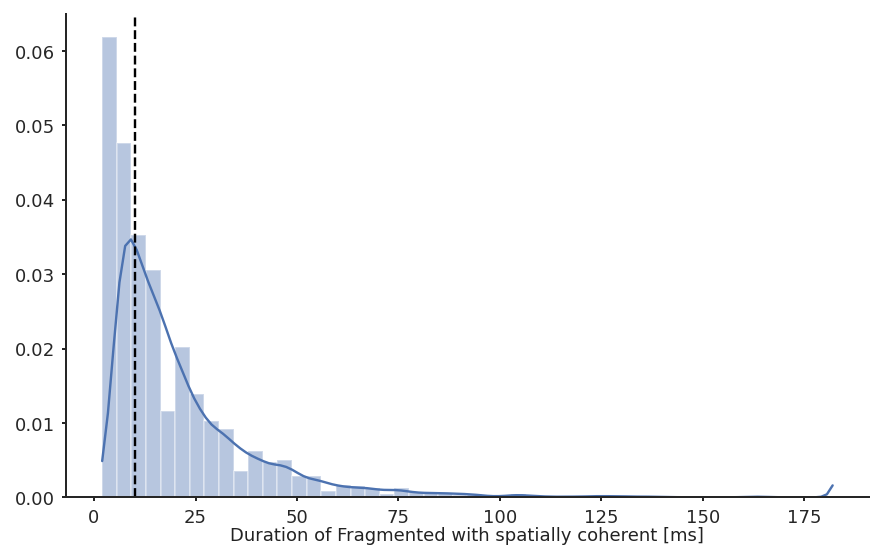

In [14]:
spatially_coherent_and_incoherent_replay_info = classified_replay_info.loc[
    has_spatially_coherent_and_incoherent
]
duration_spatially_coherent_and_incoherent_replay = (
    pd.concat(
        (
            spatially_coherent_and_incoherent_replay_info.loc[
                spatially_coherent_and_incoherent_replay_info["Fragmented"],
                "Fragmented_duration",
            ],
            spatially_coherent_and_incoherent_replay_info.loc[
                spatially_coherent_and_incoherent_replay_info[
                    "Fragmented-Continuous-Mix"
                ],
                "Fragmented-Continuous-Mix_duration",
            ],
        )
    )
    * 1000
).to_numpy()

sns.distplot(duration_spatially_coherent_and_incoherent_replay, kde_kws=dict(cut=0))
plt.axvline(10, color="black", linestyle="--")
sns.despine()
plt.xlabel("Duration of Fragmented with spatially coherent [ms]")

In [15]:
has_no_spatially_coherent_and_incoherent = (
    classified_replay_info["Fragmented"]
    | classified_replay_info["Fragmented-Continuous-Mix"]
) & ~(
    classified_replay_info["Hover"]
    | classified_replay_info["Hover-Continuous-Mix"]
    | classified_replay_info["Continuous"]
)

num = has_no_spatially_coherent_and_incoherent.sum()
denom = len(classified_replay_info)

print(
    f"Number of not spatially coherent and incoherent: {num} / {denom} or {num / denom * 100:0.0f}%\n"
)

Number of not spatially coherent and incoherent: 1244 / 24110 or 5%



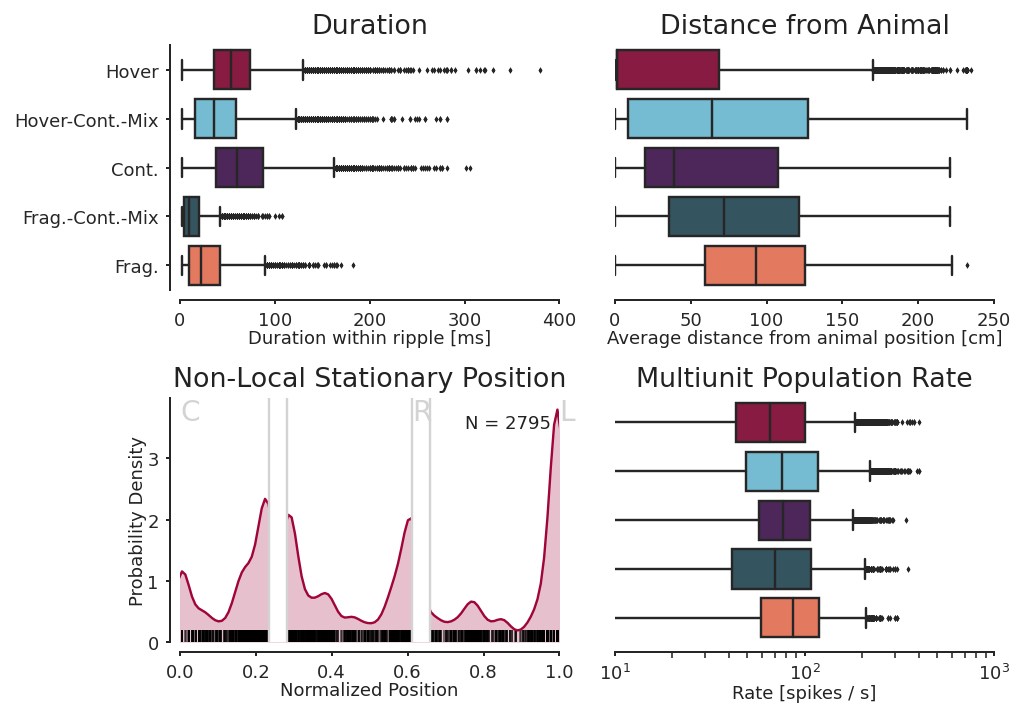

In [16]:
from src.visualization import (
    plot_replay_distance_from_actual_position,
    plot_category_duration,
    plot_linear_position_markers,
    plot_population_rate,
    _plot_category,
)

saturation, fliersize = 0.7, 1

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(TWO_COLUMN, PAGE_HEIGHT / 2), constrained_layout=True
)

# Duration of Dynamic
plot_category_duration(
    replay_info, kind="box", ax=axes[0, 0], fliersize=fliersize, saturation=saturation,
)
axes[0, 0].set_title("Duration")
axes[0, 0].set_xlim((0, 400))
sns.despine(ax=axes[0, 0], offset=5)

# Distance from Animal
plot_replay_distance_from_actual_position(
    replay_info, kind="box", ax=axes[0, 1], fliersize=fliersize, saturation=saturation
)
axes[0, 1].set_title("Distance from Animal")
sns.despine(ax=axes[0, 1], offset=5)
axes[0, 1].set_xlim((0, 250))
axes[0, 1].set_yticks([])
axes[0, 1].spines["left"].set_visible(False)

# Non-Local Stationary Position
norm_non_local_hover = (
    replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].Hover_replay_linear_position.values
    / replay_info.loc[
        replay_info.Hover_replay_distance_from_actual_position > 30
    ].left_well_position
)

sns.distplot(
    norm_non_local_hover,
    kde_kws=dict(
        bw=0.020,
        clip=(0, 1),
        shade=True,
        facecolor=STATE_COLORS["Hover"],
        legend=False,
    ),
    rug_kws=dict(color="black", alpha=0.5),
    kde=True,
    rug=True,
    hist=False,
    norm_hist=True,
    color=STATE_COLORS["Hover"],
    ax=axes[1, 0],
)
axes[1, 0].set_xlabel("Normalized Position")
axes[1, 0].set_ylabel("Probability Density")
plot_linear_position_markers(
    replay_info,
    is_normalized=True,
    jitter=0.00,
    zorder=101,
    alpha=1,
    ax=axes[1, 0],
    linestyle="-",
    fontsize=14,
)

sns.despine(ax=axes[1, 0], offset=5)
axes[1, 0].set_xlim((0, 1))
axes[1, 0].set_title("Non-Local Stationary Position")
n_non_local = norm_non_local_hover.size
axes[1, 0].text(0.75, 3.5, f"N = {n_non_local}", zorder=100, fontsize=9)

# Population firing rate
_plot_category(
    replay_info,
    "population_rate",
    kind="box",
    ax=axes[1, 1],
    fliersize=fliersize,
    saturation=saturation,
)

axes[1, 1].set_xscale("log")
axes[1, 1].set_xlim((1e1, 1e3))
axes[1, 1].set_xlabel("Rate [spikes / s]")
axes[1, 1].set_title("Multiunit Population Rate")
sns.despine(ax=axes[1, 1], offset=5)
axes[1, 1].set_yticks([])
axes[1, 1].spines["left"].set_visible(False)

In [16]:
from scipy.stats import ranksums

ranksums(replay_info.Hover_population_rate, replay_info.Continuous_population_rate)

RanksumsResult(statistic=75.13270573740348, pvalue=0.0)

In [17]:
np.nanmedian(replay_info.Hover_population_rate), np.nanmedian(
    replay_info.Continuous_population_rate
)

(65.00718390804599, 76.92307692307693)

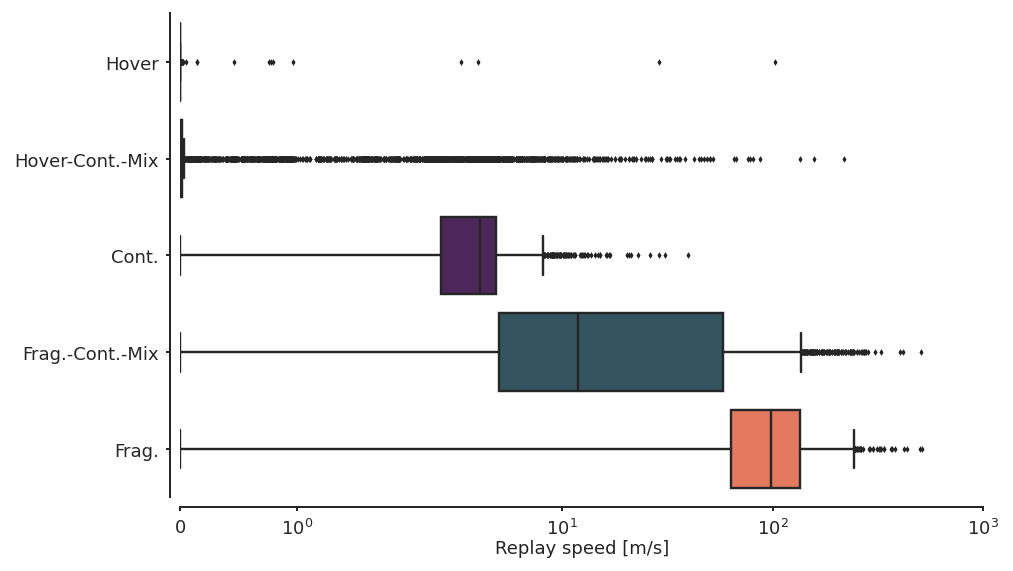

In [18]:
coherent_speeds = [
    "Hover_replay_speed",
    "Hover-Continuous-Mix_replay_speed",
    "Continuous_replay_speed",
]
incoherent_speeds = [
    "Fragmented-Continuous-Mix_replay_speed",
    "Fragmented_replay_speed",
]

all_speeds = [*coherent_speeds, *incoherent_speeds]

d = (
    replay_info.filter(all_speeds, axis=1).rename(
        columns=lambda c: SHORT_STATE_NAMES[c.split("_")[0]]
    )
    / 100
)
# d[d < 1e-2] = 1e-2

sns.boxplot(
    data=d,
    orient="horizontal",
    palette=STATE_COLORS,
    fliersize=fliersize,
    saturation=saturation,
)
plt.xscale("symlog")
plt.xlabel("Replay speed [m/s]")
plt.xlim((0, 1e3))
sns.despine(offset=5)

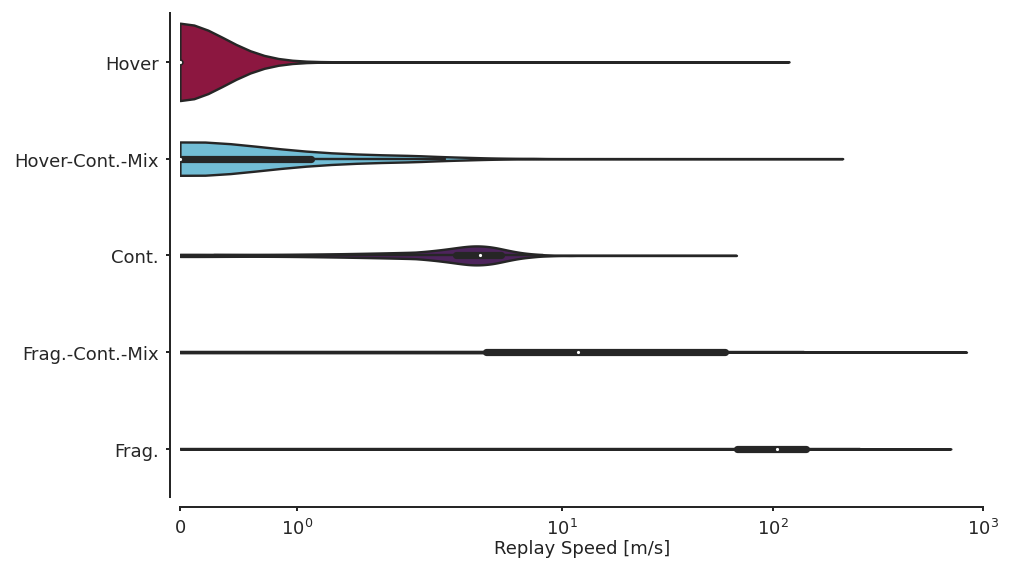

In [121]:
sns.violinplot(
    data=d,
    orient="horizontal",
    palette=STATE_COLORS,
    cut=0,
    gridsize=1000,
    inner="box",
)
plt.xscale("symlog")
plt.xlim((0, 1e3))
plt.xlabel("Replay Speed [m/s]")
sns.despine(offset=5)

In [ ]:
_plot_category(
    replay_info,
    "population_rate",
    kind="box",
    fliersize=fliersize,
    saturation=saturation,
)


(0.0, 10000.0)

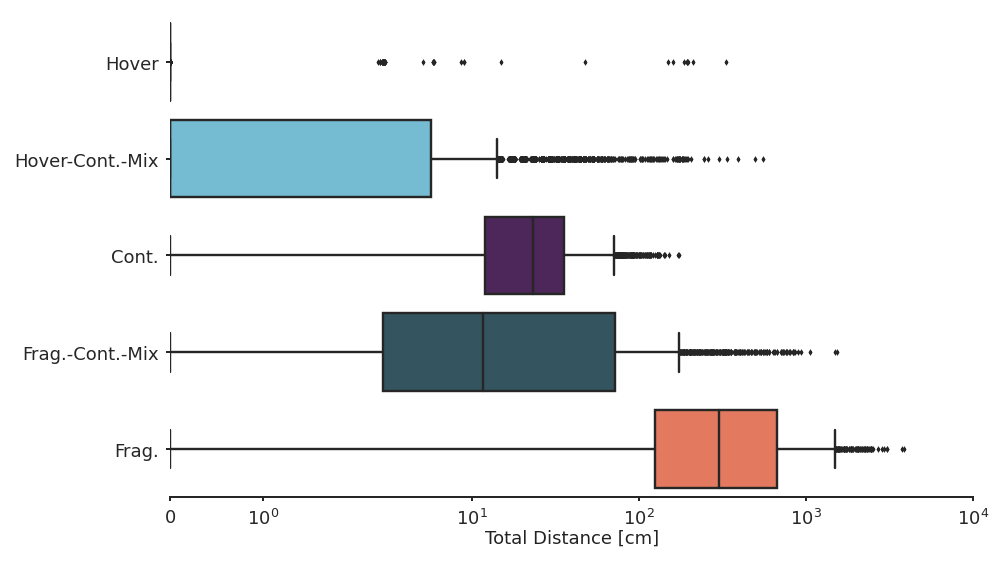

In [22]:
_plot_category(
    replay_info,
    "replay_total_distance",
    kind="box",
    fliersize=fliersize,
    saturation=saturation,
)
plt.xlabel("Total Distance [cm]")
plt.xscale("symlog")
plt.xlim((0, 1e4))

In [16]:
replay_info.loc[replay_info.loc[:, "Hover_replay_speed"] > 30].Hover_replay_speed

Animal ID  day  epoch  ripple_number
cor        2    4      41                  41.731554
           7    2      29                9668.688552
bon        3    2      146               1225.332028
                6      27                 120.150034
           4    2      20                2554.828661
                                            ...     
remy       36   2      251              11976.003637
                4      159               2591.529397
                       314                 68.338258
           37   2      328               1494.897760
                4      5                 4609.323355
Name: Hover_replay_speed, Length: 139, dtype: float64

In [17]:
num = ((replay_info.Hover_replay_distance_from_actual_position > 30)).sum()
denom = len(classified_replay_info)

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 1590 / 23382 or 7%



In [18]:
num = (
    (replay_info.Hover_replay_distance_from_actual_position > 30) & (n_states == 1)
).sum()
denom = ((replay_info.Hover_replay_distance_from_actual_position > 30)).sum()

print(f"Number of Non-Local Stationary: {num} / {denom} or {num / denom * 100:0.0f}%\n")

Number of Non-Local Stationary: 734 / 1590 or 46%



In [19]:
f"{replay_info.Hover_replay_distance_from_actual_position.max():0.0f}"

'232'

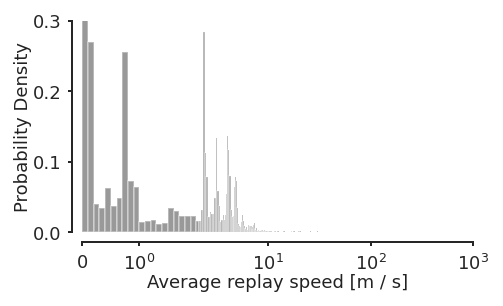

In [20]:
fig, ax = plt.subplots(figsize=(ONE_COLUMN, PAGE_HEIGHT / 5))
sns.distplot(
    replay_info.replay_speed / 100,
    ax=ax,
    bins=np.arange(0, 1e3, 0.1),
    kde_kws={"clip": (0, 1000), "bw": "silverman"},
    norm_hist=True,
    kde=False,
    color="black",
)
ax.set_xlim((0, 1000))
ax.set_ylim((0, 0.30))
ax.set_yticks((0.0, 0.1, 0.2, 0.3))
ax.set_xlabel("Average replay speed [m / s]")
ax.set_ylabel("Probability Density")
ax.set_xscale("symlog")
sns.despine(offset=5)

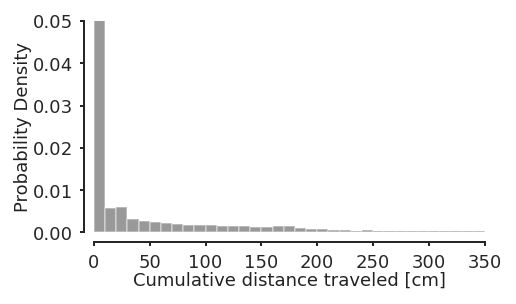

In [21]:
fig, ax = plt.subplots(figsize=(ONE_COLUMN, PAGE_HEIGHT / 5))
sns.distplot(
    replay_info.replay_total_distance,
    ax=ax,
    bins=np.arange(0, 375, 10),
    norm_hist=True,
    color="black",
    kde=False,
)
ax.set_xlim((0, 350))
ax.set_ylim((0.00, 0.05))
ax.set_xlabel("Cumulative distance traveled [cm]")
ax.set_ylabel("Probability Density")
sns.despine(offset=5)

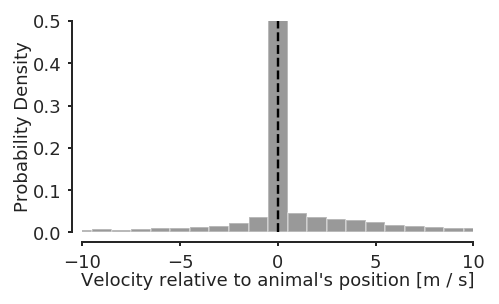

In [145]:
fig, ax = plt.subplots(figsize=(ONE_COLUMN, PAGE_HEIGHT / 5))
sns.distplot(
    replay_info.replay_velocity_actual_position / 100,
    ax=ax,
    norm_hist=True,
    bins=np.arange(-20.5, 20.5, 1),
    color="black",
    kde=False,
)
ax.set_xlim((-10, 10))
ax.set_ylim((0, 0.5))
ax.set_xlabel("Velocity relative to animal's position [m / s]")
ax.set_ylabel("Probability Density")
ax.axvline(0, color="black", linestyle="--")
sns.despine(offset=5)

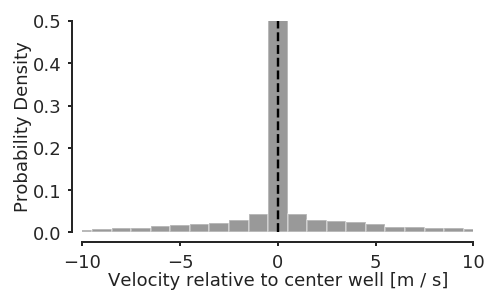

In [151]:
fig, ax = plt.subplots(figsize=(ONE_COLUMN, PAGE_HEIGHT / 5))
sns.distplot(
    replay_info.replay_velocity_center_well / 100,
    ax=ax,
    bins=np.arange(-20.5, 20.5, 1),
    norm_hist=True,
    color="black",
    kde=False,
)
ax.set_xlim((-10, 10))
ax.set_ylim((0, 0.5))
ax.set_xlabel("Velocity relative to center well [m / s]")
ax.set_ylabel("Probability Density")
ax.axvline(0, color="black", linestyle="--")
sns.despine(offset=5)

Text(0.75, 1.5, 'N = 9326')

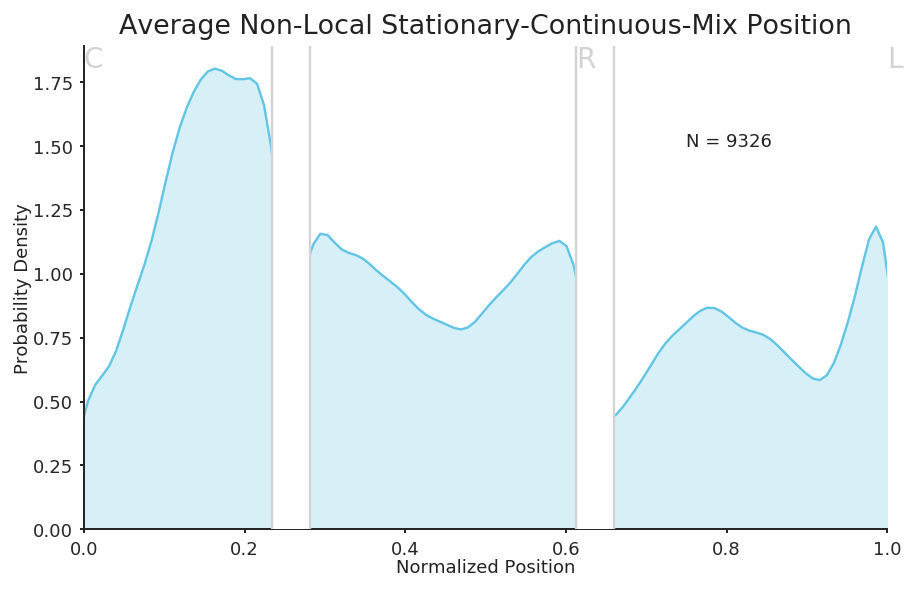

In [192]:
# Non-Local Stationary Position
norm_non_local_hover_cont_mix = (
    replay_info.loc[
        replay_info["Hover-Continuous-Mix_replay_distance_from_actual_position"] > 30
    ]["Hover-Continuous-Mix_replay_linear_position"].values
    / replay_info.loc[
        replay_info["Hover-Continuous-Mix_replay_distance_from_actual_position"] > 30
    ].left_well_position
)

fig, ax = plt.subplots(1, 1)

sns.distplot(
    norm_non_local_hover_cont_mix,
    kde_kws=dict(
        bw=0.020,
        clip=(0, 1),
        shade=True,
        facecolor=STATE_COLORS["Hover-Continuous-Mix"],
        legend=False,
    ),
    rug_kws=dict(color="black", alpha=0.5),
    kde=True,
    rug=False,
    hist=False,
    norm_hist=True,
    color=STATE_COLORS["Hover-Continuous-Mix"],
    ax=ax,
)
ax.set_xlabel("Normalized Position")
ax.set_ylabel("Probability Density")
plot_linear_position_markers(
    replay_info,
    is_normalized=True,
    jitter=0.00,
    zorder=101,
    alpha=1,
    ax=ax,
    linestyle="-",
    fontsize=14,
)

sns.despine(ax=ax)
ax.set_xlim((0, 1))
ax.set_title("Average Non-Local Stationary-Continuous-Mix Position")
n_non_local = norm_non_local_hover_cont_mix.size
ax.text(0.75, 1.5, f"N = {n_non_local}", zorder=100, fontsize=9)